# Creating a GHZ state on IQM Garnet
Creating a GHZ state is a great first job to run on IQM Garnet as your first circuit.

In this notebook, you will learn how to ...
* ... create a GHZ state with IQM Garnet.

By the end of this notebook, you will not only have a solid understanding of how to execute a circuit on IQM Garnet, but you will also appreciate the subtleties that differentiate various quantum computing architectures and their impact on quantum information processing. This exploration will provide you with the skills that are essential for advancing with this new quantum computing architecture and making full use of the computational resonator to advance the field of quantum computing.

### Installing the necessary packages
In order to get started, make sure you have the appropriate packages installed:

In [9]:
%%capture
!pip install "iqm-client[qiskit]"
!pip install networkx
!pip install rustworkx
!pip install matplotlib
!pip install pylatexenc

In order to access IQM Garnet through IQM Resonance, you will need to create an API Token. Copy the token, execute the cell, and paste the token to store it as an environment variable (or follow the guidelines for your system to create an environment variable).

In [10]:
import os
os.environ["IQM_TOKEN"] = input()

## Connecting to IQM Garnet

Let's first check that our connection is working.

We do this by authenticating ourselves to IQM Resonance.

In [11]:
from iqm.qiskit_iqm import IQMProvider

# Instead of setting the environment variable, you could add the token as an argument to the IQMProvider constructor
provider=IQMProvider(url="https://cocos.resonance.meetiqm.com/garnet")
backend = provider.get_backend()

Then we can access the IQM Garnet backend and plot its connectivity graph to check that everything is working properly.

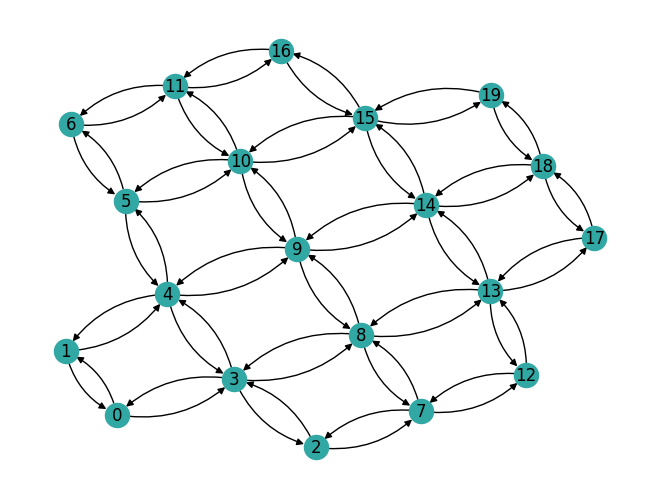

In [12]:
from rustworkx.visualization import mpl_draw
from rustworkx import spring_layout

mpl_draw(backend.coupling_map.graph, arrows=True, with_labels=True, node_color='#32a8a4', pos=spring_layout(backend.coupling_map.graph, num_iter=200))

## Creating the GHZ state using a simulator

The GHZ (Greenberger-Horne-Zeilinger) state is a maximally entangled quantum state that involves three or more qubits. It is an equal superposition of all qubits being in state 0 and all qubits being in state 1. We will use 10 qubits of the 20, we have available on IQM Garnet, this can be represented as:

$$\frac{1}{2}(∣00000000000⟩+ ∣11111111111⟩)$$

If we want to create a GHZ state for a simulator without considering connectivity constraints given by actual quantum computing hardware, we can just do the folllowing:

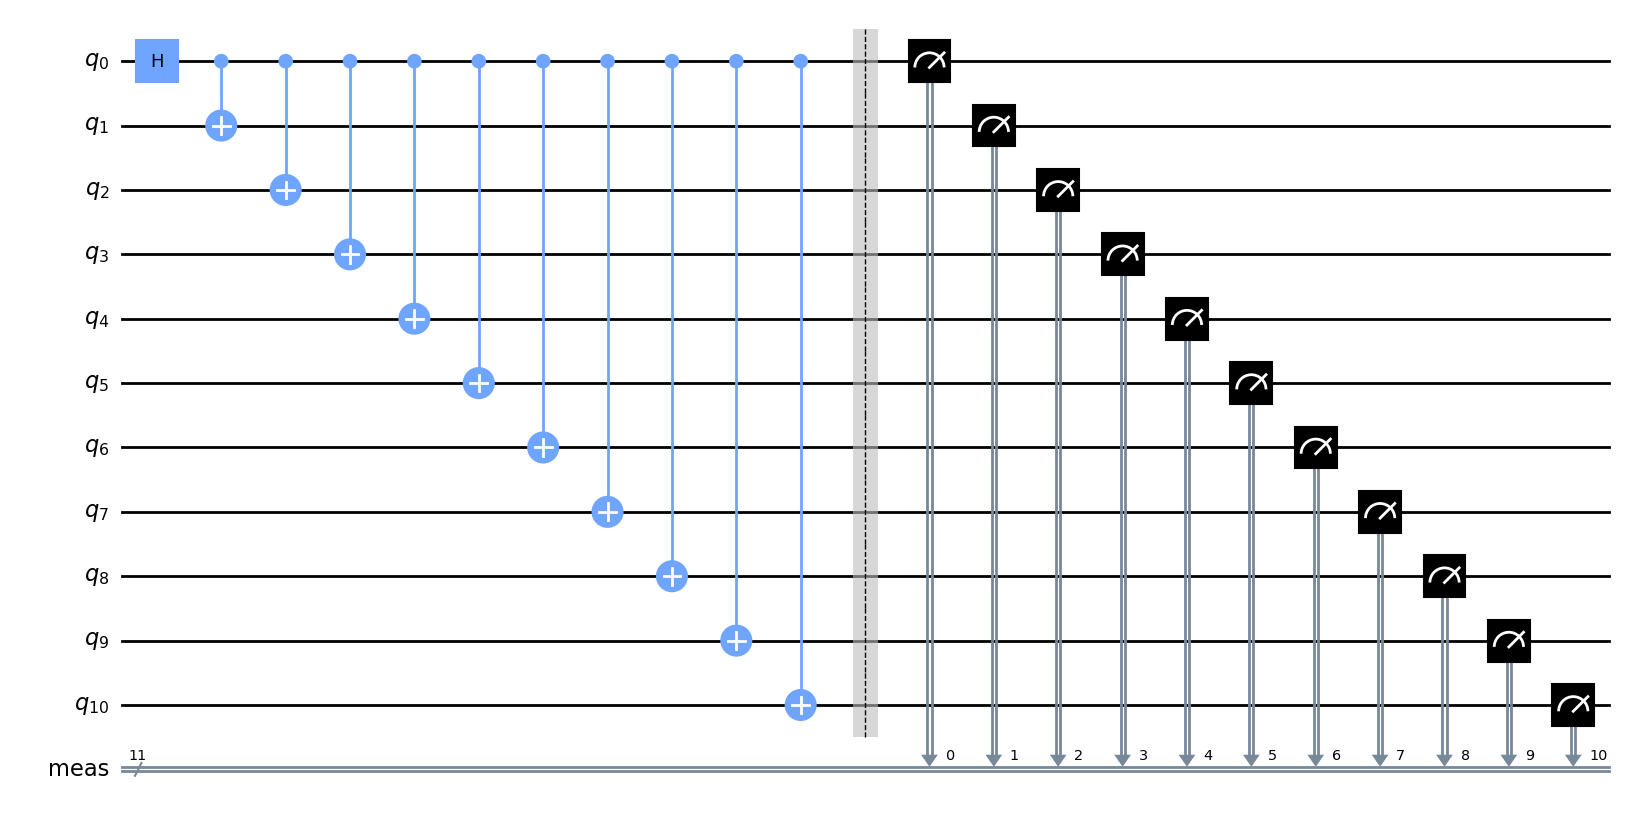

In [13]:
from qiskit import QuantumCircuit

num_qb = 11
qc = QuantumCircuit(num_qb)

qc.h(0)
for qb in range(1, num_qb):
    qc.cx(0, qb)

qc.measure_all()
qc.draw("mpl",  style="clifford")

## Creating the GHZ state with IQM Garnet

When adapting GHZ state generation to the square lattice topology, as seen in IQM Garnet, we can tune our circuit to

In order to create a GHZ state, we follow the steps below:

<ol>
<li> First, we initiate the process by <b>creating a superposition</b> using a Hadamard gate <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">H</span> on a qubit.
</li>
<li>  Then, we <b>apply <span style="display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">CNOT</span> gates from one qubit to three other qubits to utilize the connectivity of a square grid</b>.
</li>
<li> Finally, we perform <b>measurements on all qubits. 
</li>
</ol>

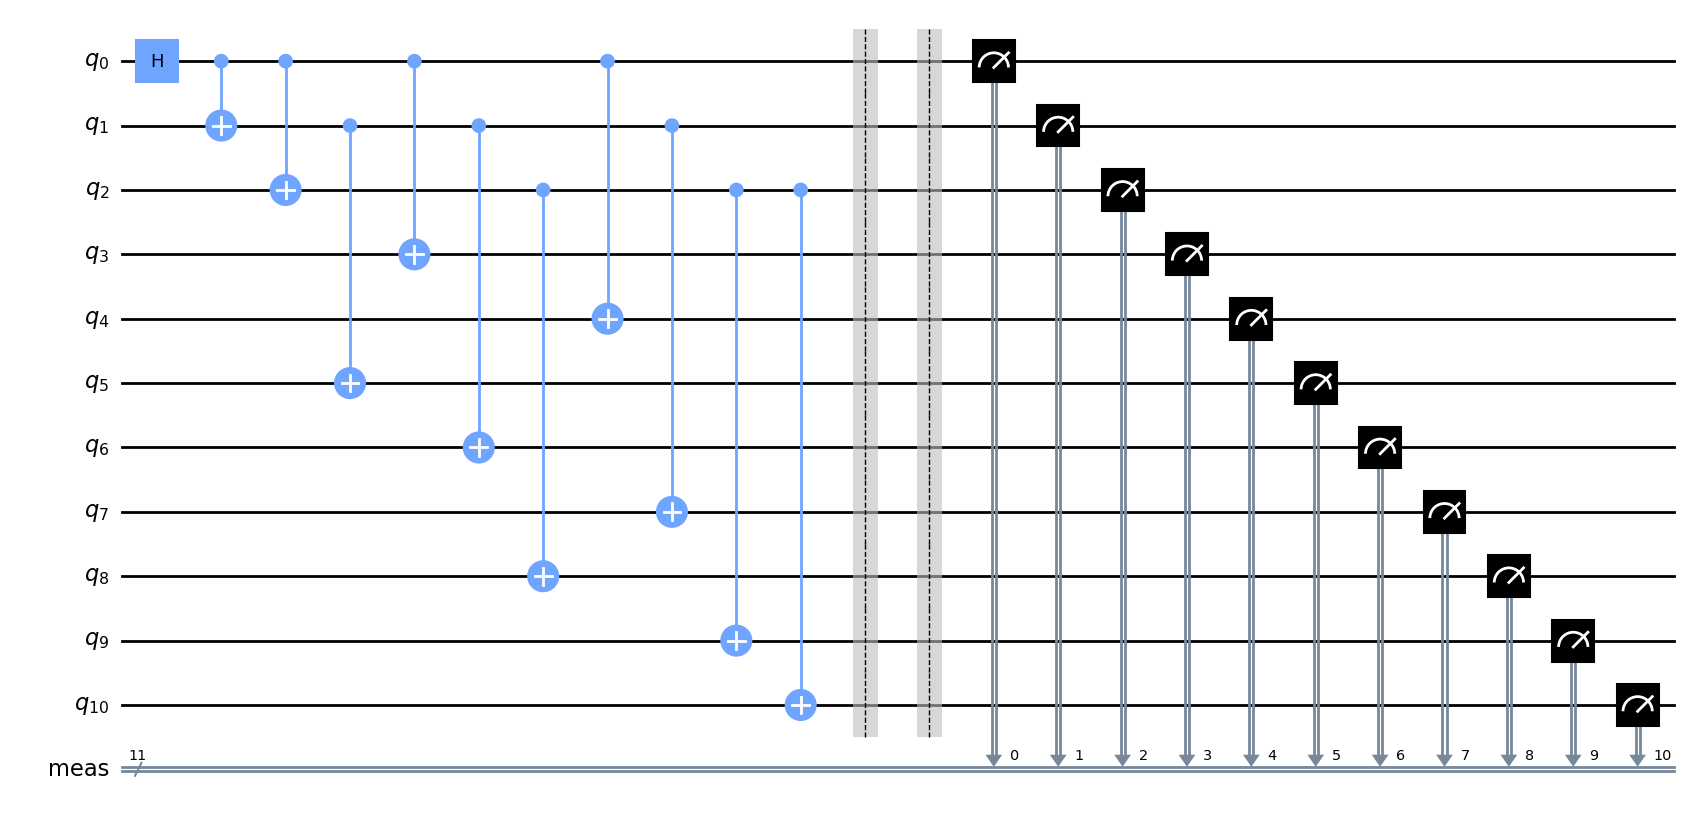

In [14]:
from qiskit.visualization import plot_histogram

# Create Quantum Registers and Quantum Circuit
qc = QuantumCircuit(num_qb)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 2)
qc.cx(0, 3)
qc.cx(0, 4)
qc.cx(1, 5)
qc.cx(1, 6)
qc.cx(1, 7)
qc.cx(2, 8)
qc.cx(2, 9)
qc.cx(2, 10)

qc.barrier()
qc.measure_all()
qc.draw("mpl", style="clifford")


<div style="background-color: white; margin: 20px 0px; padding: 20px; border-left: 3px solid rgb(222, 199, 84);">
With the circuit prepared, we can now send it to our quantum computer and examine the results. Therefore, we need to transpile the circuit which will apply several transpilation steps, including decomposing the <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">CNOT</span> gate into native gates. After that we can call the `run` method on the backend to execute the circuit.
</div>

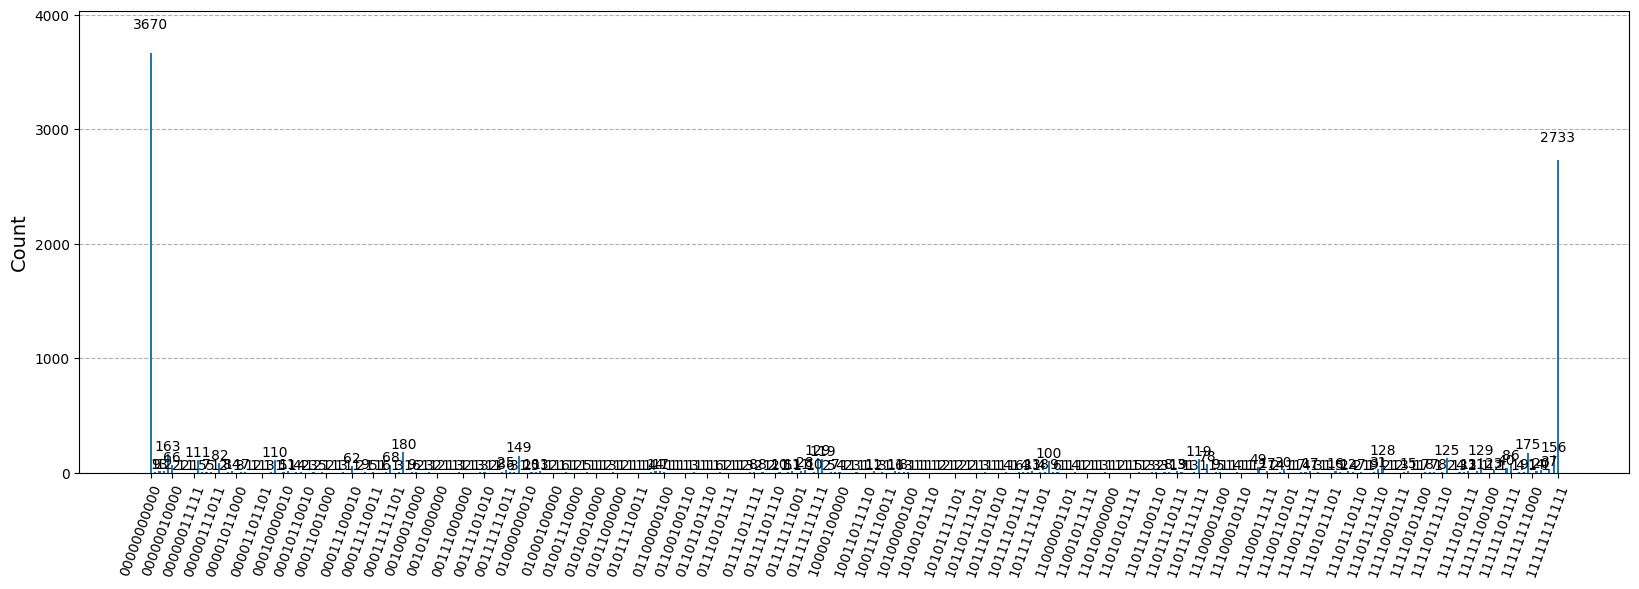

In [18]:
from qiskit import transpile
import matplotlib.pyplot as plt

qc_transpiled = transpile(qc, backend)
job = backend.run(qc_transpiled, shots=10000)

import qiskit
if qiskit.__version__ < '1.0.0':
    # The job monitor is only compatible with qiskit versions smaller than 1.0
    from qiskit.tools.monitor import job_monitor
    job_monitor(job)

res=job.result()
counts=res.get_counts()

#Plot the results
from qiskit.visualization import plot_histogram
import numpy as np

fig, ax = plt.subplots(figsize=(20, 6))
plot_histogram(counts, ax=ax)

desired_ticks = 2**6   ### decreasing the total number of tick labels to have a clean figure
x_ticks = np.linspace(0, len(counts)-1, desired_ticks, dtype=int)
ax.set_xticks(x_ticks)

plt.show()


The result looks indeed like a GHZ state: We observe two distinct peaks corresponding to the bitstrings composed entirely of zeros and entirely of ones. The remaining counts are indicative of noise and errors within the system. 

As the plot is quite hard to read with all the different possible outcomes, let's only check how many out of our 10,000 shots actually turned out to be $∣00000000000⟩$ or $∣11111111111⟩)$. For this, we can sort the results obtained and see that we have around 6500 shots of the 10.000 that yielded either all zeros or all ones.

In [16]:
# sort the counts
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
sorted_counts

{'00000000000': 3341,
 '11111111111': 2210,
 '11111111011': 335,
 '00000000100': 234,
 '11100000100': 225,
 '11011111111': 216,
 '10111111111': 215,
 '00011111011': 154,
 '00010000000': 153,
 '11111110111': 127,
 '11111011111': 107,
 '00011111111': 106,
 '00100000000': 102,
 '10000000000': 100,
 '11110111111': 89,
 '00000010000': 88,
 '01111111111': 85,
 '00000001000': 81,
 '11111111110': 79,
 '00001000000': 79,
 '11101111111': 77,
 '00000000001': 76,
 '00011100010': 75,
 '01000000000': 69,
 '11111101111': 63,
 '00000100000': 47,
 '11100011101': 38,
 '11011111011': 35,
 '11000000100': 35,
 '10100000100': 33,
 '10111111011': 29,
 '11111100110': 27,
 '01111111011': 25,
 '11111111101': 25,
 '11111011011': 23,
 '11100111101': 22,
 '10011111111': 22,
 '00111111011': 21,
 '00111111111': 20,
 '11100000000': 19,
 '01011111111': 19,
 '11011110111': 18,
 '11111101110': 18,
 '11111110011': 17,
 '11100001100': 13,
 '11011111110': 13,
 '10111110111': 13,
 '10000000100': 13,
 '00000101000': 13,
 '11

Now it's your turn, take the code above and the qubit layout to create an even bigger GHZ state. You can also experiment further and apply error mitigation schemes to reduce these errors.

In [17]:

# Copyright 2024 IQM Quantum Computers (Hermanni Heimonen, Stefan Seegerer)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.